<a href="https://colab.research.google.com/github/mckang6113875/AP_Test_OPEN/blob/main/SVM_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#6113875

In [1]:
! git clone https://github.com/mckang6113875/AP_Test_OPEN.git

fatal: destination path 'AP_Test_OPEN' already exists and is not an empty directory.


(720, 1140, 3)


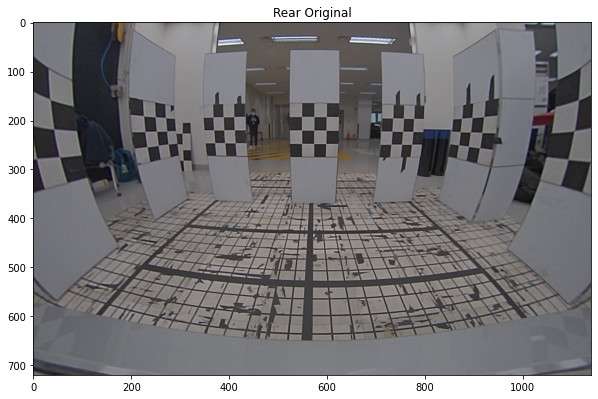

In [112]:
import cv2
import matplotlib.pyplot as plt
#original = cv2.imread('/content/AP_Test_OPEN/RS4_F_1.png')
#original = cv2.imread('/content/AP_Test_OPEN/SX2_R_1.bmp')
original = cv2.imread('/content/AP_Test_OPEN/ViewMode_R.bmp')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

#img = cv2.imread('/content/AP_Test_OPEN/RS4_F_1.png')
#img = cv2.imread('/content/AP_Test_OPEN/SX2_R_1.bmp')
img = cv2.imread('/content/AP_Test_OPEN/ViewMode_R.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(10, 10))
plt.imshow(original)
plt.title('Rear Original')
#plt.grid(color='white', linestyle='--', linewidth=1)
#plt.xticks(np.arange(0, original.shape[1], 50));
#plt.yticks(np.arange(0, original.shape[0], 50));
print(original.shape)

## Only CV2 Function
- getOptimalNewCameraMatrix
- undistort

True
[[ 35.16669961   0.         569.99999975]
 [  0.         758.33547005 359.99999955]
 [  0.           0.           1.        ]]
[[ 42.35974998   0.         571.88057609]
 [  0.         805.08460693 360.25881544]
 [  0.           0.           1.        ]]


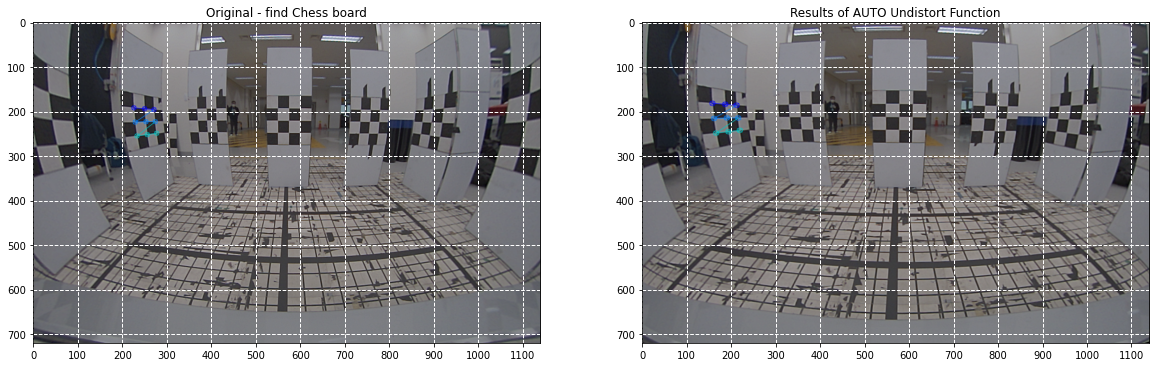

In [122]:
import numpy as np
import cv2

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
wc = 3
hc = 3

objp = np.zeros((wc*hc,3), np.float32)
objp[:, :2] = np.mgrid[0:wc, 0:hc].T.reshape(-1,2)

objpoints = []
imgpoints = []

img1 = cv2.resize(img, dsize = (img.shape[1], img.shape[0]), interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, (wc, hc), None)
print(ret)

if ret == True:
  objpoints.append(objp)
  corners2 = cv2.cornerSubPix(gray, corners, (10,10), (-1, -1), criteria) #10, 10
  imgpoints.append(corners2)

  img2 = cv2.drawChessboardCorners(img1, (wc, hc), corners2, ret)

  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
  h, w = img2.shape[:2]
  newcameramtx2, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0.7) #0.5

  img3 = cv2.undistort(img2, mtx, dist)
  img4= cv2.undistort(img2, mtx, dist, None, newcameramtx2)

  fig = plt.figure(figsize=(20, 10))
  plt.subplot(121)
  plt.imshow(img2)
  plt.title('Original - find Chess board')
  plt.grid(color='white', linestyle='--', linewidth=1)
  plt.xticks(np.arange(0, img2.shape[1], 100))
  plt.yticks(np.arange(0, img2.shape[0], 100))
  plt.subplot(122)
  plt.imshow(img4)
  plt.title('Results of AUTO Undistort Function')
  plt.grid(color='white', linestyle='--', linewidth=1)
  plt.xticks(np.arange(0, img4.shape[1], 100))
  plt.yticks(np.arange(0, img4.shape[0], 100))
  
print(mtx), print(newcameramtx2);